In [248]:
import numpy as np
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
from tf.transformations import euler_from_quaternion, quaternion_from_euler

\begin{array}{|l|l|l|}
\hline ID & Test name & Description \\
\hline 1 & \terowt { Firowed (0.0) } & \terowt { Top wheel 0, Yaw target 0 } \\
\hline 2 & \terowt { Firowed (0.0) } & \terowt { Top wheel 0, Yaw target 0 } \\
\hline 3 & \terowt { Firowed (6.0) } & \text { Top wheel 6, Yaw target 0 } \\
\hline 4 & \text { Fixed (-6.0) } & \text { Top wheel -6, Yaw target 0 } \\
\hline 5 & \text { Fixed (9.0) } & \text { Top wheel 9, Yaw target 0 } \\
\hline 6 & \text { Fixed (-9.0) } & \text { Top wheel -9, Yaw target 0 } \\
\hline 7 & \text { Fixed (0.5) } & \text { Top wheel 0, Yaw target 3 } \\
\hline 8 & \text { Fixed (0.-5) } & \text { Top wheel 0, Yaw target -3 } \\
\hline 9 & \text { Fixed (-6.-5) } & \text { Top wheel -6, Yaw target -3 } \\
\hline
\end{array}

All tests are done with constant X-velocity: 0.05 m/s

In [249]:
# Load experiment data
b_exp1 = bagreader('odom_test.bag')
# b_exp2 = bagreader('secondary_2023-04-21-13-59-49_0.bag')

[INFO]  Data folder odom_test already exists. Not creating.


In [250]:
odom_true1 = b_exp1.message_by_topic('rr_robot/odom')
odom_kin1 = b_exp1.message_by_topic('rr_robot/cmd_vel_controller/kin/odom')
odom_imu = b_exp1.message_by_topic('rr_robot/cmd_vel_controller/imu/odom')

cmdvel_kin = b_exp1.message_by_topic('rr_robot/cmd_vel_controller/cmd_vel')



df_odom_true = pd.read_csv(odom_true1)
df_odom_kin = pd.read_csv(odom_kin1)
df_odom_imu = pd.read_csv(odom_imu)
df_cmdvel_kin = pd.read_csv(cmdvel_kin)

#contact = pd.read_csv(contact)


# df_odom_true2 = pd.read_csv(odom_true2)
# df_odom_kin2 = pd.read_csv(odom_kin2)

# df_odom_true = df_odom_true1.append(df_odom_true2)
# df_odom_kin = df_odom_kin1.append(df_odom_kin2)

In [251]:
dfs = [df_odom_true, df_odom_kin, df_odom_imu]
for df in dfs:
    df["Angles"] = [euler_from_quaternion(
                    [df["pose.pose.orientation.x"][id], df["pose.pose.orientation.y"][id], df["pose.pose.orientation.z"][id], df["pose.pose.orientation.w"][id]])[-1] for id in df.index]

In [252]:
# angles_kin = [euler_from_quaternion(
# [df_odom_kin["pose.pose.orientation.x"][id], df_odom_kin["pose.pose.orientation.y"][id], df_odom_kin["pose.pose.orientation.z"][id], df_odom_kin["pose.pose.orientation.w"][id]])[-1] for id in df_odom_kin.index]

In [253]:
# angles_true = [euler_from_quaternion(
# [df_odom_true["pose.pose.orientation.x"][id], df_odom_true["pose.pose.orientation.y"][id], df_odom_true["pose.pose.orientation.z"][id], df_odom_true["pose.pose.orientation.w"][id]])[-1] for id in df_odom_true.index]

In [254]:
# df_odom_kin["Angles"] = angles_kin
# df_odom_true["Angles"] = angles_true

In [255]:
headers = ["pose.pose.position.x", "pose.pose.position.y", "Angles", "twist.twist.linear.x", "twist.twist.linear.y", "twist.twist.angular.z"]
labels = ["x-position [m]", "y-position [m]", "yaw-angle [rad]", r"x-velocity [$\frac{m}{s}$]", r"y-velocity [$\frac{m}{s}$]", r"angular-velocity [$\frac{rad}{s}$]"]

In [256]:
def TrimToStart(df, tstart):
    df.drop(df[df["Time"]<tstart].index, inplace=True)
    df.Time -= tstart

def CalibrateZero(df):
    for col in headers:
        df[col] =  df[col] - df[col][df[col].index[0]]

In [257]:
time_kin = df_cmdvel_kin.Time[0]
for df in dfs:
    TrimToStart(df, time_kin)
    CalibrateZero(df)

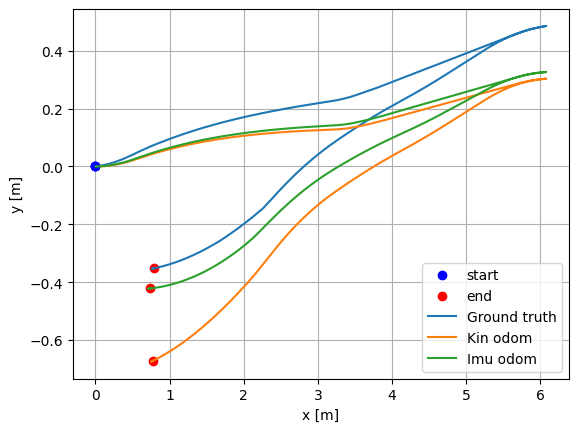

In [258]:
fig, ax = plt.subplots(nrows=1, ncols=1)
first = True
for df, name in zip(dfs, ["Ground truth", "Kin odom", "Imu odom"]):
    start = (df['pose.pose.position.x'][df.index[0]], df['pose.pose.position.y'][df.index[0]])
    stop = (df['pose.pose.position.x'][df.index[-1]], df['pose.pose.position.y'][df.index[-1]])
    if first:
        ax.plot(*start, "bo", label="start")
        ax.plot(*stop, "ro", label="end")
        first = False
    else:
        ax.plot(*start, "bo")
        ax.plot(*stop, "ro")
    df.plot(ylim=[-10, 10], x='pose.pose.position.x', xlabel='x [m]', y="pose.pose.position.y", ylabel="y [m]", label=name, legend=True, grid=True, ax=ax)
ax.legend()
ax.autoscale(True)

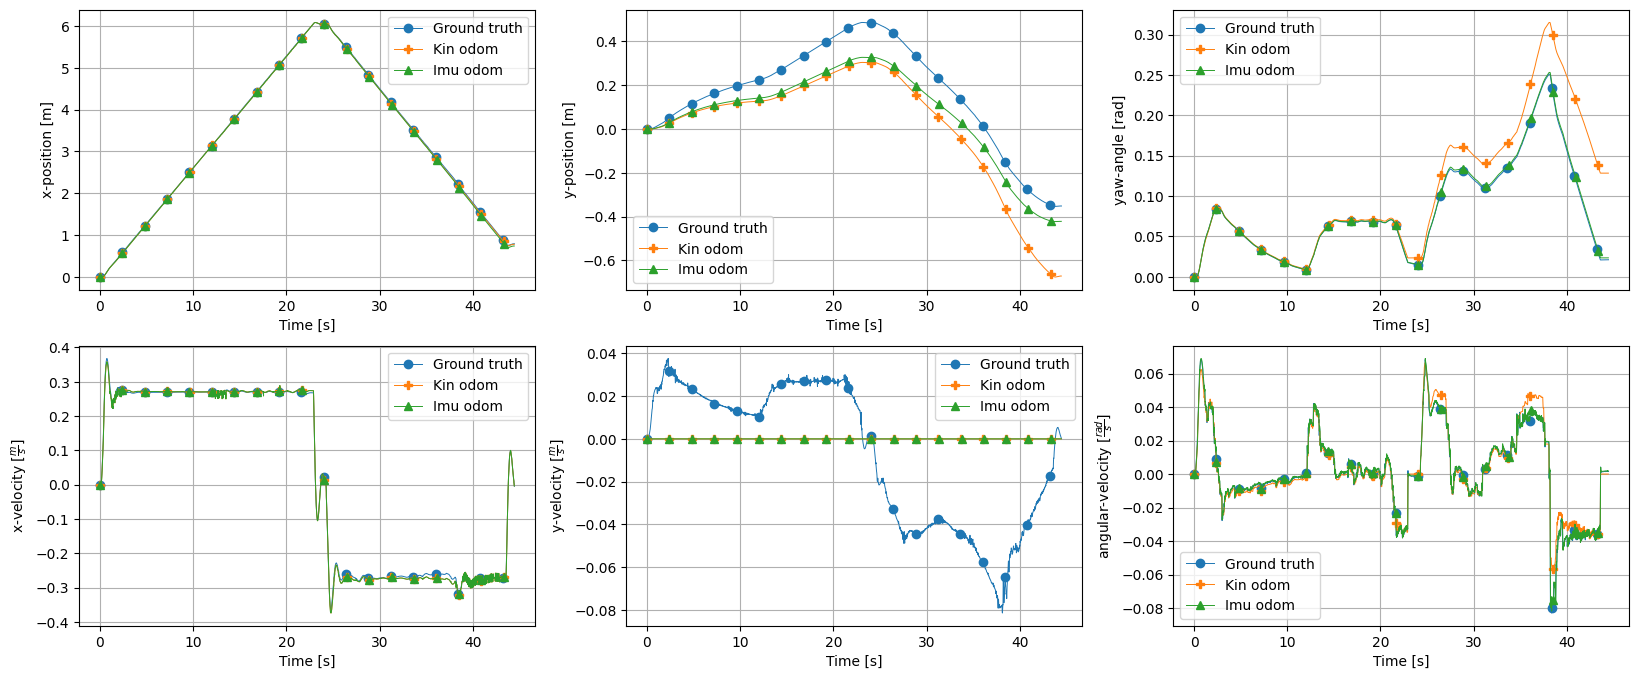

In [259]:
markers = ["o-", "P-", "^-"]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
axs = axs.reshape(-1)

for df, name, marker, every in zip(dfs, ["Ground truth", "Kin odom", "Imu odom"], markers, [120, 120, 120]):
    for (header, label), ax in zip(zip(headers,labels), axs):
        df.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y=header, ylabel=label, grid=True, legend=True, ax=ax, label=name, linewidth=0.7, marker=marker[0], linestyle=marker[1], markevery=every)
for ax in axs:
    ax.autoscale(True)


In [260]:
# contact.data = contact.data.replace({True: 1, False: 0})
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,8))

# contact.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y="data", ylabel="Is contacting", grid=True, legend=False, ax=ax)
# ax.autoscale(True)
